In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from result_saver import SaverProvider
from soft_info import get_counts
from Scratch import metadata_helper, metadata_loader


# Generate data

In [3]:
provider = SaverProvider()
backend = provider.get_backend('ibmq_manila')

In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0, 0)
print(qc.draw(fold=-1))

initial_layout = [0]
transpiled_qc = transpile(qc, backend, initial_layout=initial_layout, optimization_level=0)

print(transpiled_qc.draw(fold=-1))

     ┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 
               ┌───┐┌─┐
      q_0 -> 0 ┤ X ├┤M├
               └───┘└╥┘
ancilla_0 -> 1 ──────╫─
                     ║ 
ancilla_1 -> 2 ──────╫─
                     ║ 
ancilla_2 -> 3 ──────╫─
                     ║ 
ancilla_3 -> 4 ──────╫─
                     ║ 
          c: 1/══════╩═
                     0 


job_metadata = metadata_helper(sampled_state=1, num_qubits=1)
job_id = backend.run(job_metadata, transpiled_qc, shots=1e6, meas_level=1, meas_return='single').job_id()

# KDE Fitting

In [5]:
data = metadata_loader(extract=True)
filtered_data = data[(data['shots'] == 1e6) & (data['job_status'] != 'JobStatus.ERROR')]
filtered_data

,creation_date,notebook_name,backend_name,job_id,job_name,job_metadata,tags,meas_level,init_qubits,meas_return,skip_transpilation,shots,memory,sampled_state,num_qubits,job_status,extra,optimization_level
0,2023-10-24 17:40:45.994179+02:00,KDE_Jak,ibmq_manila,cmvyazbk20pg008epbzg,NaN,{},[],1.0,True,single,True,1000000.0,False,1,1.0,JobStatus.DONE,NaN,NaN
1,2023-10-24 17:38:13.246957+02:00,KDE_Jak,ibmq_manila,cmvy9sf23ve0008zm1bg,NaN,{},[],1.0,True,single,True,1000000.0,False,0,1.0,JobStatus.DONE,NaN,NaN
2,2023-10-24 15:42:07.022802+02:00,plot_IQ_2,ibmq_manila,cmvwkbnjad30008ec01g,NaN,{},[],1.0,True,single,True,1000000.0,False,11,2.0,JobStatus.DONE,20 CXs,NaN
3,2023-10-24 14:57:23.519080+02:00,KDE_Jak,ibmq_jakarta,cmvvycsvpdgg008geya0,NaN,{},[],1.0,True,single,True,1000000.0,False,11,2.0,JobStatus.DONE,3 CXs,NaN


In [6]:
memories = {}

for job_id, sampled_s in zip(filtered_data.job_id, filtered_data.sampled_state):
    job = provider.retrieve_job(job_id)
    name = f"memory_{int(sampled_s)}_state"
    memories[name] = job.result().get_memory()

memories

{'memory_1_state': array([[ 13056256.-28170030.j],
        [ 13009988.-30052476.j],
        [ 24301122.-34140467.j],
        ...,
        [-11841316.-26943650.j],
        [ 18260363.-43577543.j],
        [ 32649675.-37288473.j]]),
 'memory_0_state': array([[-24905016.-19712283.j],
        [-15529562.-28771109.j],
        [-22304150.-31635795.j],
        ...,
        [-24769099.-26568381.j],
        [ -9517937.-27805681.j],
        [ -7834668.-43302056.j]]),
 'memory_11_state': array([[ 39336276.-5.80343120e+07j,  35651180.-2.13073650e+07j],
        [-21155615.+2.23481200e+07j,   2396680.-4.34121050e+07j],
        [ 58311299.-6.99214350e+07j,   4777609.-5.49934610e+07j],
        ...,
        [ 38365813.-9.75613090e+07j,  47176031.-2.18815880e+07j],
        [ 58786118.-1.03008886e+08j,   3275578.-5.38754450e+07j],
        [ 54067954.-4.28352180e+07j, -25826251.-6.54351190e+07j]])}

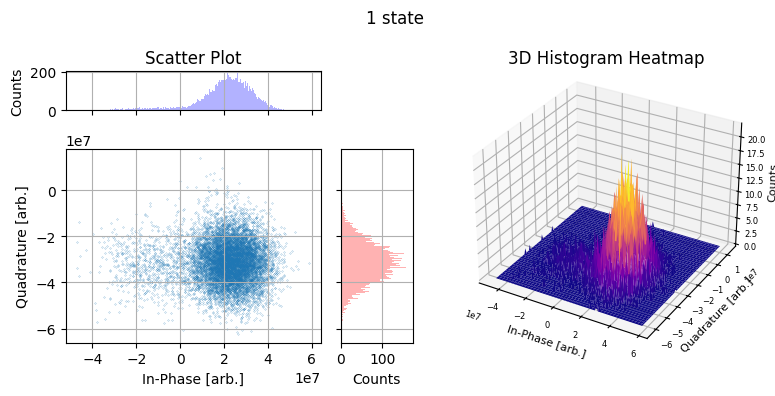

[[ 13056256. -28170030.]
 [ 13009988. -30052476.]
 [ 24301122. -34140467.]
 [ 25949167. -26166173.]]


Text(0.5, 1.0, 'combined_data')

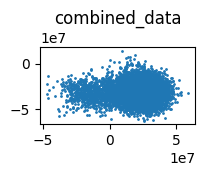

In [7]:
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from soft_info import plot_IQ_data

data = memories['memory_1_state'] # rescale for better fitting
data = data[:int(1e4)]
plot_IQ_data(data, title='1 state')

data = data.flatten()

# Create an array of shape (N, 2) to hold the real and imaginary parts
combined_data = np.column_stack((data.real, data.imag))
print(combined_data[:4])
plt.figure(figsize=(2,1))
plt.scatter(combined_data[:, 0], combined_data[:, 1], s=1)
plt.title("combined_data")



Text(0.5, 1.0, 'Normalized data')

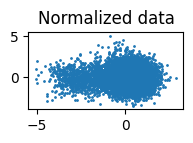

In [8]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(combined_data)
#normalized_data = combined_data
plt.figure(figsize=(2,1))
plt.scatter(normalized_data[:, 0], normalized_data[:, 1], s=1)
plt.title('Normalized data')

In [10]:
# Perform 2D KDE
bandwidth = 0.1
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
kde.fit(normalized_data)
print(kde.bandwidth)

0.1


In [26]:
X_samle = np.array([[1, -3], [1, 3], [2,-3], [1, 0]])
log_proba_dens_func = kde.score_samples(X_samle)
proba_dens_func = np.exp(kde.score_samples(X_samle))
print("log_proba_dens_func:", log_proba_dens_func)
print("proba_dens_func:", proba_dens_func)


log_proba_dens_func: [ -7.86563223  -7.98331262 -15.18746716  -2.17685219]
proba_dens_func: [3.83706650e-04 3.41107589e-04 2.53610260e-07 1.13397925e-01]


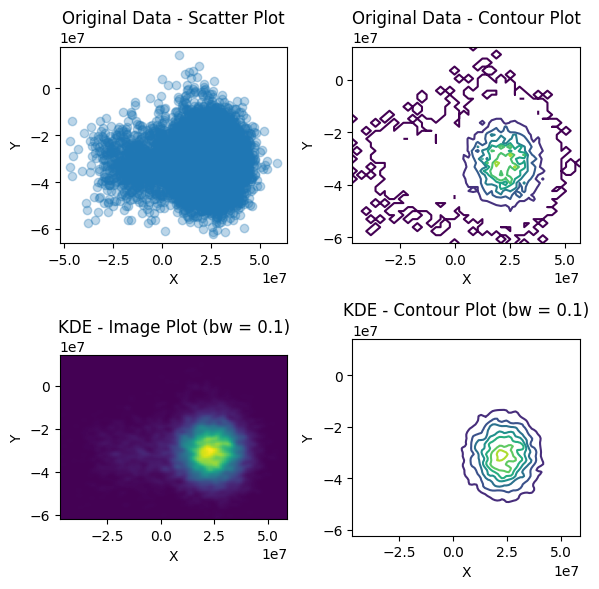

In [27]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

data  = combined_data

# Scatter plot of original data
axs[0, 0].scatter(data[:, 0], data[:, 1], alpha=0.3, label='Original Data')
axs[0, 0].set_title('Original Data - Scatter Plot')

# Contour plot of original data
nbins = 50
hist, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=nbins)
axs[0, 1].contour(xedges[:-1], yedges[:-1], hist.T, cmap='viridis')
axs[0, 1].set_title('Original Data - Contour Plot')



# Generate the grid where we will evaluate the KDE
x_grid = np.linspace(min(data[:, 0]) - 1, max(data[:, 0]) + 1, 100)
y_grid = np.linspace(min(data[:, 1]) - 1, max(data[:, 1]) + 1, 100)
xv, yv = np.meshgrid(x_grid, y_grid)
gridpoints = np.array([xv.ravel(), yv.ravel()]).T

# Evaluate the 2D KDE on the grid
log_dens = kde.score_samples(scaler.transform(gridpoints))
dens = np.exp(log_dens).reshape(xv.shape)

# Image plot of the KDE
axs[1, 0].imshow(dens, extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]], origin='lower', cmap='viridis')
axs[1, 0].set_title(f'KDE - Image Plot (bw = {bandwidth})')

# Contour plot of the KDE
axs[1, 1].contour(x_grid, y_grid, dens, cmap='viridis')
axs[1, 1].set_title(f'KDE - Contour Plot (bw = {bandwidth})')

# Add labels and titles
for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

plt.tight_layout()
plt.show()